### Load data, see DatasetLoader.ipynb

In [1]:
import os

TRAIN_PATH = "../../Dataset/ManualSegmentation"
REFERENCE_PATH = "../../Dataset/withGT/"
#TEST_PATH = "../../Dataset/MHA/Test"

if not os.path.exists(TRAIN_PATH):
    print("Please update your data path to an existing folder.")
elif not '.mha' in os.listdir(TRAIN_PATH)[0]:
    print("The folder exists there are no MHA files found.")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


180


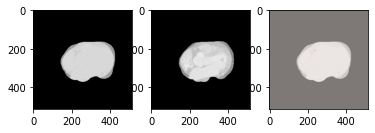

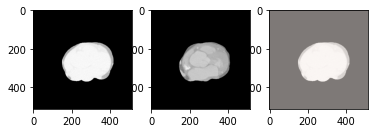

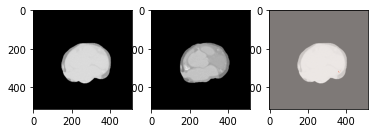

The distrubution of annotations in the trainset
Ratio with GT: 100.0 %
Area of GT in total: 0.021601782904730905 %


In [3]:
# from torch.utils.data import Dataset
from monai.data import Dataset
import torchsummary
import torch
import itk
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, regImg_ext, transforms=None):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.images = self.load_mha_images(imagePaths,['CTI',regImg_ext,'R'])
		self.loadedImages = self.images['CTI']
		self.loadedMask = self.images['R']
		self.transforms = transforms

	def load_mha_images(self, paths, ext):
		img = dict()
		counter_reference = 0
		for i in paths:
			if len(ext)>1:
				R_image = np.clip(itk.GetArrayFromImage(itk.imread(REFERENCE_PATH + i.split('/')[-1]+""+ext[2]+".mha")),0,1)
				CTI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[0]+"_2.mha"))
				CTAI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[1]+".mha"))
				if not (len(CTI_image) == len(CTAI_image) == len(R_image)):
					raise ValueError("Lengths (slices) of "+i+" are not the same!")
				for j in range(len(CTI_image)):				
					if 1 in R_image[j]:
						if ext[0] in img:
							img[ext[0]].append(torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j]))))
							img[ext[2]].append(torch.FloatTensor(R_image[j]))
						else:
							img[ext[0]] = [torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j])))]
							img[ext[2]] = [torch.FloatTensor(R_image[j])]
		return img

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.images['CTI'])

	def __getitem__(self, idx):
		# grab the image path from the current index
		image = self.loadedImages[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		mask = self.loadedMask[idx]
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

train_image_CTI_paths = list(filter(lambda x: 'CTI' in x,os.listdir(TRAIN_PATH)))
train_image_paths = []
for i in train_image_CTI_paths:
    train_image_paths.append(TRAIN_PATH+"/"+i[:6])


train_dataset = SegmentationDataset(train_image_paths,'CTAI_0')
print(len(train_dataset))

for i in range(3):
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[1].imshow(train_dataset[i][0][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
    axes[2].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds,alpha=0.5)	# [i][1] 	GT
    plt.show()

count = 0
sumation = 0

for i in train_dataset:
    if 1 in i[1].numpy():
        sumation += np.sum(i[1].numpy())
        count += 1

print("The distrubution of annotations in the trainset")
print("Ratio with GT:",count/len(train_dataset)*100,"%")
print("Area of GT in total:",sumation/(len(train_dataset)*512*512)*100,"%")

In [4]:
from sklearn.svm import SVC
from sklearn import metrics
from skimage import feature
from sklearn.model_selection import train_test_split
import progressbar
from numpy.lib import stride_tricks
import mahotas as mt
import pickle as pkl

def test_model(X, y, model):

    pred = model.predict(X)
    precision = metrics.precision_score(y, pred, average='weighted')
    recall = metrics.recall_score(y, pred, average='weighted')
    f1 = metrics.f1_score(y, pred, average='weighted')
    accuracy = metrics.accuracy_score(y, pred)
    return (precision, recall, f1, accuracy)

def create_training_dataset(train_dataset):
    X = []
    y = []
    i = 0
    bar = progressbar.ProgressBar(maxval=len(train_dataset), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()

    for img, label in train_dataset:
        img = img.permute(1,2,0).numpy()
        img = np.append(img,np.zeros((img.shape[0],img.shape[1],1)),axis=2)
        features, labels = create_features(img, img[:,:,0]+img[:,:,1], label.numpy())
        X.append(features)
        y.append(labels)
        i+=1
        bar.update(i)
    
    bar.finish()
        
    X = np.array(X)
    X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    y = np.array(y)
    y = y.reshape(y.shape[0]*y.shape[1], y.shape[2]).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print ('[INFO] Feature vector size:', X_train.shape)

    return X_train, X_test, y_train, y_test

def subsample_idx(low, high, sample_size):
    return np.random.randint(low,high,sample_size)

def calc_haralick(roi):
    feature_vec = []
    texture_features = mt.features.haralick(roi.astype(int))
    mean_ht = texture_features.mean(axis=0)
    [feature_vec.append(i) for i in mean_ht[0:9]]
    return np.array(feature_vec)

def create_binary_pattern(img, p, r):
    lbp = feature.local_binary_pattern(img, p, r)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255

def harlick_features(img, h_neigh, ss_idx):
    size = h_neigh
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    strides = 2 * img.strides
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = patches.reshape(-1, size, size)

    # if len(ss_idx) == 0 :
    #     bar = progressbar.ProgressBar(maxval=len(patches), \
    #     widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # else:
    #     bar = progressbar.ProgressBar(maxval=len(ss_idx), \
    #     widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    # bar.start()

    h_features = []

    if len(ss_idx) == 0:
        for i, p in enumerate(patches):
            h_features.append(calc_haralick(p))
    else:
        for i, p in enumerate(patches[ss_idx]):
            h_features.append(calc_haralick(p))

    #h_features = [calc_haralick(p) for p in patches[ss_idx]]

    return np.array(h_features)

def create_features(img, img_gray, label, train=True):

    lbp_radius = 64 # local binary pattern neighbourhood
    h_neigh = 19 # haralick neighbourhood
    num_examples = 1000 # number of examples per image to use for training model

    lbp_points = lbp_radius*8
    h_ind = int((h_neigh - 1)/ 2)

    feature_img = np.zeros((img.shape[0],img.shape[1],4))
    feature_img[:,:,:3] = img
    img = None
    feature_img[:,:,3] = create_binary_pattern(img_gray, lbp_points, lbp_radius)
    feature_img = feature_img[h_ind:-h_ind, h_ind:-h_ind]
    features = feature_img.reshape(feature_img.shape[0]*feature_img.shape[1], feature_img.shape[2])

    if train == True:
        ss_idx = subsample_idx(0, features.shape[0], num_examples)
        features = features[ss_idx]
    else:
        ss_idx = []

    h_features = harlick_features(img_gray, h_neigh, ss_idx)
    features = np.hstack((features, h_features))

    if train == True:

        label = label[h_ind:-h_ind, h_ind:-h_ind]
        labels = label.reshape(label.shape[0]*label.shape[1], 1)
        labels = labels[ss_idx]
    else:
        labels = None

    return features, labels


In [5]:
def train_model(model,train_ds):
    model.fit(train_ds[0],train_ds[1])
    return model

folder_name = "hugefield"
model_name = "model_manualseg_v3"
if os.path.exists(folder_name+'/'+model_name):
    model = pkl.load(folder_name+'/'+model_name)
else: 
    model = SVC(class_weight='balanced')

    X_train, X_test, y_train, y_test = create_training_dataset(train_dataset)
    train_ds = (X_train,y_train)
    test_ds = (X_test,y_test)
    np.save(folder_name+'/'+model_name+'.npy',(train_ds,test_ds))

    # train_ds,test_ds = np.load(model_name,allow_pickle=True)
    # train_ds,test_ds = np.load('SVM_preprocessing.npy',allow_pickle=True)

    model = train_model(model,train_ds)
print(test_model(test_ds[0],test_ds[1], model))



[========================================================================] 100%
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[INFO] Feature vector size: (144000, 13)
(0.9997821428571428, 0.9983055555555556, 0.9989590212291651, 0.9983055555555556)


In [6]:
# https://github.com/dgriffiths3/ml_segmentation/tree/ba57108af9504432b69052eaf251c92a2d428043
pkl.dump(model, open(folder_name+'/'+model_name, "wb"))

Entry: 0
[0. 1.]..                  
0.6714285714285715 1.0 0.7919191919191919 0.828125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


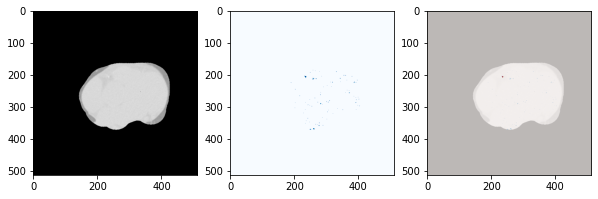

Entry: 1
[0. 1.]..                  
0.4166666666666667 1.0 0.5777777777777778 0.853515625


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


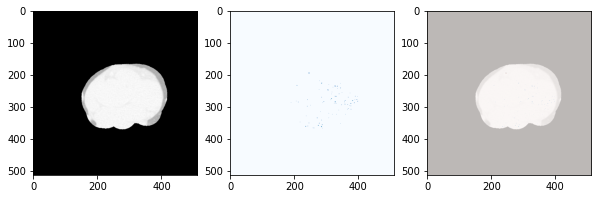

Entry: 2
[0. 1.]..                  
0.7573853615520282 1.0 0.8521053791887125 0.892578125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


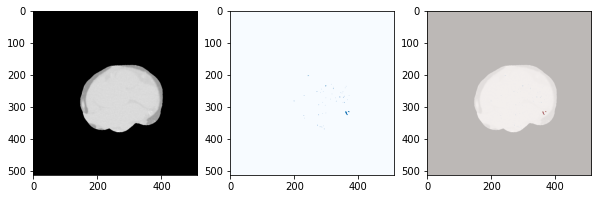

Entry: 3
[0. 1.]..                  
0.7785714285714286 1.0 0.8683261183261183 0.908203125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


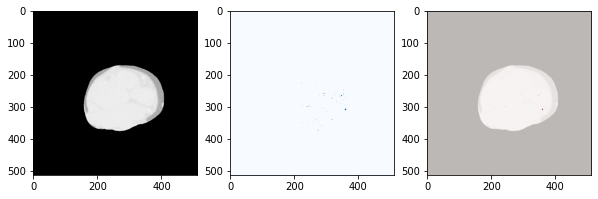

Entry: 4
[0. 1.]..                  
0.3833333333333333 1.0 0.5416666666666666 0.923828125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


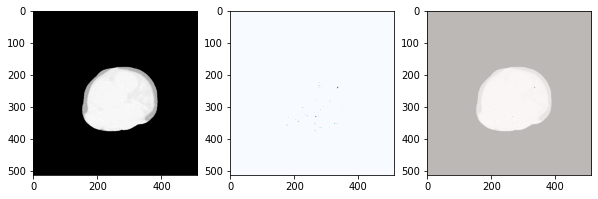

Entry: 5
[0. 1.]..                  
0.8247354497354498 1.0 0.8968389635056302 0.923828125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


Entry: 6
[0. 1.]..                  
0.7701298701298701 1.0 0.8557624193987831 0.8125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


Entry: 7
[0. 1.]..                  
0.8819444444444444 1.0 0.9245430495430497 0.79296875


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


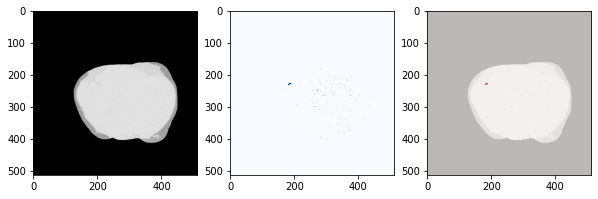

Entry: 8
[0. 1.]..                  
0.7619047619047619 1.0 0.8476190476190475 0.947265625


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


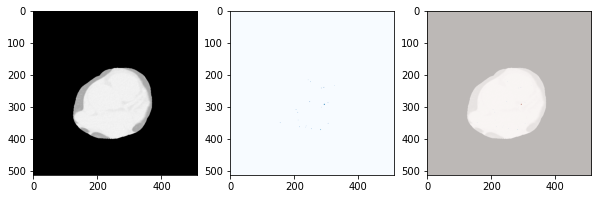

Entry: 9
[0. 1.]..                  
0.6171536796536796 1.0 0.7479109274563819 0.626953125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


Entry: 10
[0. 1.]..                  
0.5507384772090653 1.0 0.7048380541027599 0.609375


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


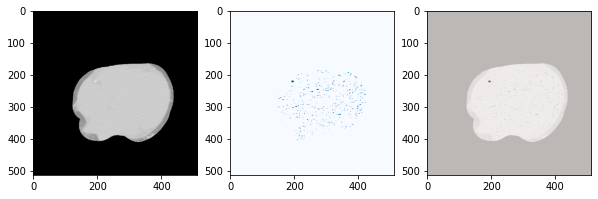

Entry: 11
[0. 1.]..                  
0.6457556935817806 1.0 0.7780632411067193 0.685546875


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


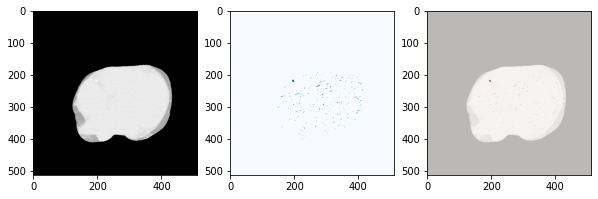

Entry: 12
[0. 1.]..                  
0.6350418811957272 1.0 0.7725067960362078 0.666015625


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


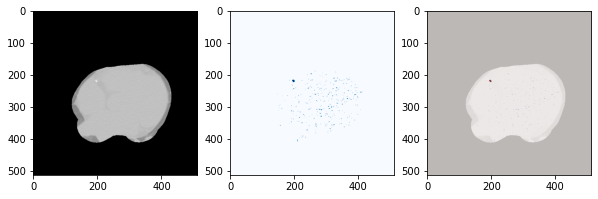

Entry: 13
[0. 1.]..                  
0.8550642479213908 1.0 0.913938882986502 0.841796875


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


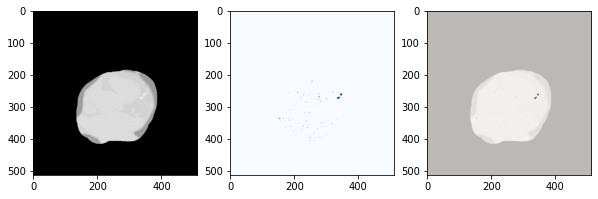

Entry: 14
[0. 1.]..                  
0.8079861111111111 1.0 0.8895280645280645 0.86328125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


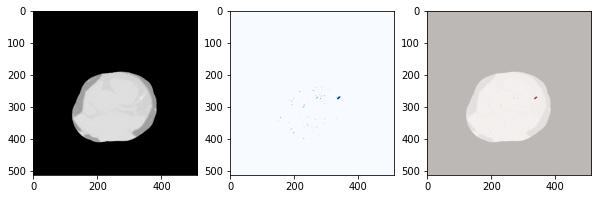

Entry: 15
[0. 1.]..                  
0.8482143272562434 1.0 0.9136401604735526 0.943359375


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


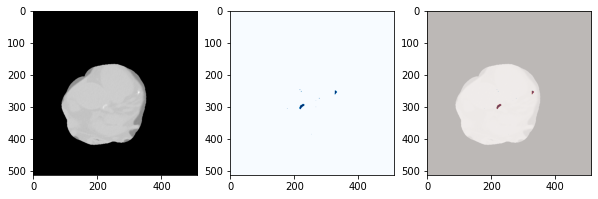

Entry: 16
[0. 1.]..                  
0.8965921826429074 1.0 0.9425921662159286 0.95703125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


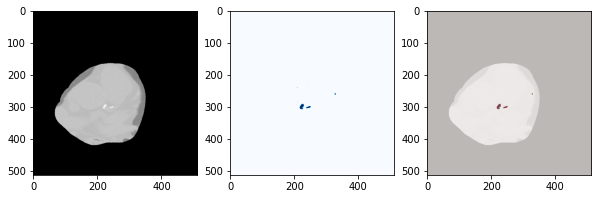

Entry: 17
[0. 1.]..                  
0.6666666666666666 1.0 0.7766666666666666 0.87109375


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


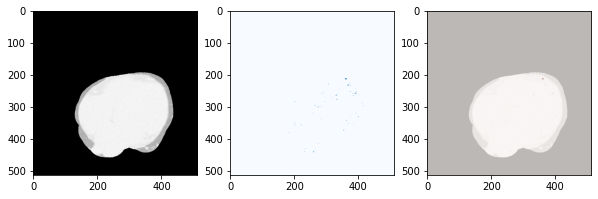

Entry: 18
[0. 1.]..                  
0.8235521235521236 1.0 0.8978549978549979 0.939453125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


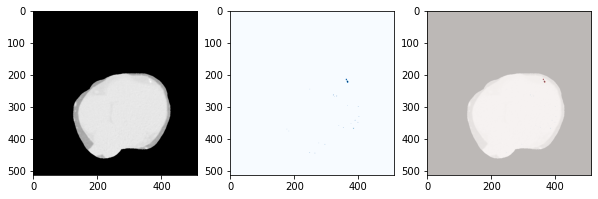

Entry: 19
[0. 1.]..                  
0.753927738927739 1.0 0.8471559629013786 0.828125


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.


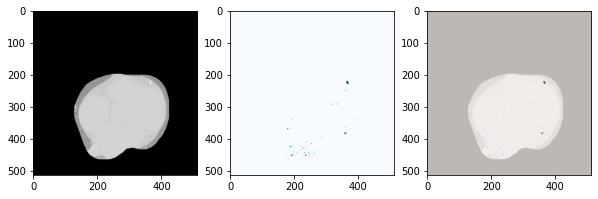

[(0.6714285714285715, 1.0, 0.7919191919191919, 0.828125), (0.4166666666666667, 1.0, 0.5777777777777778, 0.853515625), (0.7573853615520282, 1.0, 0.8521053791887125, 0.892578125), (0.7785714285714286, 1.0, 0.8683261183261183, 0.908203125), (0.3833333333333333, 1.0, 0.5416666666666666, 0.923828125), (0.8247354497354498, 1.0, 0.8968389635056302, 0.923828125), (0.7701298701298701, 1.0, 0.8557624193987831, 0.8125), (0.8819444444444444, 1.0, 0.9245430495430497, 0.79296875), (0.7619047619047619, 1.0, 0.8476190476190475, 0.947265625), (0.6171536796536796, 1.0, 0.7479109274563819, 0.626953125), (0.5507384772090653, 1.0, 0.7048380541027599, 0.609375), (0.6457556935817806, 1.0, 0.7780632411067193, 0.685546875), (0.6350418811957272, 1.0, 0.7725067960362078, 0.666015625), (0.8550642479213908, 1.0, 0.913938882986502, 0.841796875), (0.8079861111111111, 1.0, 0.8895280645280645, 0.86328125), (0.8482143272562434, 1.0, 0.9136401604735526, 0.943359375), (0.8965921826429074, 1.0, 0.9425921662159286, 0.95703

In [9]:
# To show output image
import cv2
import math
import random

def compute_prediction(i, IMG, model):
    y = IMG[1].numpy()
    print("Prepping image..."+' '*10,end='\r')
    if os.path.exists(folder_name+'/'+'feature_'+str(i)+'.npy'):
        features = np.load(folder_name+'/'+'feature_'+str(i)+'.npy')
    else:
        img = IMG[0]
        img = img.permute(1,2,0).numpy()
        img = np.append(img,np.zeros((img.shape[0],img.shape[1],1)),axis=2)
        img = cv2.copyMakeBorder(img,9,9,9,9,cv2.BORDER_CONSTANT,value=[0, 0, 0])
        print("Get Features..."+' '*10,end='\r')
        features,_ = create_features(img, img[:,:,0]+img[:,:,1], label=None, train=False)
        print("Saving..."+' '*10,end='\r')
        np.save(folder_name+'/'+'feature_'+str(i)+'.npy',features)
    print("Predicting..."+' '*10,end='\r')
    pred = model.predict(features.reshape(-1, features.shape[1]))
    pred_size = int(math.sqrt(features.shape[0]))
    print("Resize..."+' '*10,end='\r')
    inference_img = pred.reshape(pred_size, pred_size)
    print(np.unique(inference_img))
    print("Analysis metrics..."+' '*10,end='\r')
    precision = metrics.precision_score(y, inference_img, average='weighted')
    recall = metrics.recall_score(y, inference_img, average='weighted')
    f1 = metrics.f1_score(y, inference_img, average='weighted')
    accuracy = metrics.accuracy_score(y, inference_img)
    print("Done..."+' '*10,end='\r')
    return inference_img, (precision, recall, f1, accuracy)

outputlist = []
for j in range(20):
    i = j #round(random.random()*(len(train_dataset)-1))
    print("Entry:",i)
    print("Running..."+' '*10,end='\r')
    fig, axes = plt.subplots(1,3)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    inference_img, (precision, recall, f1, accuracy) = compute_prediction(i,train_dataset[i], model)
    print("Plotting..."+' '*10,end='\r')
    axes[0].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[1].imshow(inference_img,cmap=plt.cm.Blues) # [i][0][1] CTA
    axes[2].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[2].imshow(inference_img,cmap=plt.cm.Blues,alpha=0.5) # [i][0][1] CTA
    axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds,alpha=0.5)	# [i][1] 	GT
    print(precision, recall, f1, accuracy)
    outputlist.append((precision, recall, f1, accuracy))
    plt.show() 
    fig.savefig(folder_name+'/'+'output_'+str(i)+'.png')

print(outputlist)
